# **Predicting Building Permit Issuance Times**
##                                                                                             ...and answering many questions!


**A Data Science Project**     
*by Aparna Shastry*

## Content 

+ Introduction / Scope
+ Predictive Modeling
+ Scope for Future Work
+ Conclusion
+ References

### Introduction / Scope of this Notebook
A detailed introduction to the problem, data and data cleaning part is explained in the first part of the project notebook in the same folder, by name BuildingPermitSFODataWrangling.ipynb  

Exploratory Data Analysis and Inferential Statistics is done in the second part of the notebook, BuildingPermitSFO-EDA.ipynb 

This notebook handles the predictive modeling part, and gives conclusions/scope for future work.

In [1]:
import os
import pandas as pd
import numpy as np
import time
import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")
sns.set_context("talk")

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve, auc, f1_score

C:\Users\Aparn\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Aparn\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Define a few sub-routines used below

In [2]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=2, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    #print(gs.grid_scores_)
    best = gs.best_estimator_
    return best


def pre_process_Xy(Xarray,yarray,test_tr_split_size=0.4,dev_test_split_size=0.5) :
    '''Function to split given data into test and (train, dev) set'''
    Xtr,Xte,ytr,yte = train_test_split(Xarray,yarray,test_size=test_tr_split_size,random_state=42,stratify=yarray)
    Xte,Xdev,yte,ydev = train_test_split(Xte,yte,test_size=dev_test_split_size,random_state=21,stratify=yte)
    return Xtr,Xdev,Xte,ytr,ydev,yte
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def plot_train_test_error(clf,X,y,N=50):
    '''This function plots Train and Test Accuracy for different lengths'''

    training_error = np.empty([N,1])
    dev_error = np.empty([N,1])
    len_tr = int(X.shape[0]/N)
    re_ind = np.random.permutation(X.index)
    X = X.reindex(re_ind)
    y = y.reindex(re_ind)
    for i in range(N) :
        X1 = X[:(i+1)*len_tr]
        y1 = y[:(i+1)*len_tr]
        Xtr,Xte,ytr,yte = train_test_split(X1,y1,test_size=0.5,random_state=42,stratify=y1)
        clf = clf.fit(Xtr, ytr)
        training_error[i,0] = 1 - clf.score(Xtr, ytr)
        dev_error[i,0] = 1 - clf.score(Xte, yte)
    
    plt.plot(np.arange(N)*len_tr,training_error.reshape(np.arange(N).shape),label='train error')
    plt.plot(np.arange(N)*len_tr,dev_error.reshape(np.arange(N).shape),color='m',label='test error')
    plt.title('Train Error and Test Error Vs Number of Samples used (train: test 1:1 ratio)')
    plt.ylabel('Error rate')
    plt.xlabel('Number of samples')
    plt.legend(loc='best')
    return
    
def do_classify(clf, parameters, Xtr,ytr,Xdev,ydev, score_func=None, n_folds=5, n_jobs=2,model_name='LogReg',label=1,prob_dec=1,print_detail=1):

    if parameters:
        clf = cv_optimize(clf, parameters, Xtr, ytr, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtr, ytr)
    training_accuracy = clf.score(Xtr, ytr)
    test_accuracy = clf.score(Xdev, ydev)
    ypred =  clf.predict(Xdev)
    print("############# " + model_name+" ################")
    print("Accuracy on training data: %0.2f" % (100*training_accuracy)+'%')
    print("Accuracy on test data:     %0.2f" % (100*test_accuracy)+'%')
    if print_detail == 1 :
        print("confusion_matrix on dev data")
        print(confusion_matrix(ydev,ypred))
        print("classification report on dev data")
        print(classification_report(ydev,ypred))
        print("########################################################")
    else :
        print("f1 score:  %0.2f" % f1_score(ydev,ypred,average="weighted"))
    return clf

def convert_categories(y) :
    '''Function to convert a numerical variable into 5 categories''' 
    if y < 8:
        z = 0
    elif y < 92 :
        z = 1
    else :
        z = 2
    return z


In [3]:
# Retrieve Dataframe
%store -r sfrtomodel

In [4]:
sfrtomodel.head()

,perm_typ,perm_typ_def,file_dt,issue_dt,cur_st,strct_notif,no_exist_stry,no_prop_stry,fire_only_permit,est_cost,...,file_day,issue_day,month,year,latitude,longitude,issue_mod,quarter,log_rev_cost,time_taken_str
0,4,sign - erect,2015-05-06,2015-11-09,expired,N,6.0,NaN,N,4000.0,...,Wednesday,Monday,5,2015,37.785719,-122.408523,2015-11-09,2,8.294050,187
1,4,sign - erect,2016-04-19,2017-08-03,issued,N,7.0,NaN,N,1.0,...,Tuesday,Thursday,4,2016,37.787340,-122.410632,2017-08-03,2,6.214608,471
3,8,otc alterations permit,2016-11-07,2017-07-18,complete,N,2.0,2.0,N,2000.0,...,Monday,Tuesday,11,2016,37.795959,-122.415574,2017-07-18,4,7.600902,253
4,6,demolitions,2016-11-28,2017-12-01,issued,N,3.0,NaN,N,100000.0,...,Monday,Friday,11,2016,37.783153,-122.409509,2017-12-01,4,11.512925,368
5,8,otc alterations permit,2017-06-14,2017-07-06,issued,N,5.0,5.0,Y,4000.0,...,Wednesday,Thursday,6,2017,37.759223,-122.391704,2017-07-06,2,8.294050,22


In [5]:
sfr = sfrtomodel.copy()

### **Predictive Modeling**

This section tries to fit a model on the data to predict whether building permit will be issued within a week, 3 months or after 3 months. We could do some feature engineering first and keep them ready.

#### Feature Engineering

In [6]:
# Create Polynomial features:
sfr = sfr.assign(log_rev_cost_2 = sfr.log_rev_cost**2)
sfr = sfr.assign(log_rev_cost_3 = sfr.log_rev_cost**3)

In [7]:
# Generate some more features
sfr[sfr['exist_use'] != sfr['prop_use']].groupby('perm_typ').time_taken.describe()
sfr = sfr.assign(dff_use = 1*(sfr['exist_use'] != sfr['prop_use']))
sfr = sfr.assign(diff_stry=1*(sfr.no_prop_stry != sfr.no_exist_stry))

#### Defining Machine Learning Classification Problem

In [8]:
# Make target variable
y = sfr.loc[:,'time_taken'].copy()
y = y.apply(convert_categories)
y_dist = (y.value_counts()/y.count())
pd.DataFrame(np.round(y_dist,3))

,time_taken
0,0.718
1,0.151
2,0.130


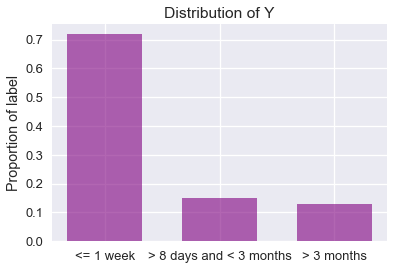

In [9]:
objects = ('<= 1 week', '> 8 days and < 3 months', '> 3 months')
y_pos = np.arange(len(objects))
performance = list(y_dist)
bar_width = 0.65
_ = plt.bar(y_pos, performance, bar_width,align='center', alpha=0.6,color='purple')
_ = plt.xticks(y_pos, objects)
_ = plt.ylabel('Proportion of label')
_ = plt.title('Distribution of Y')

#### Extract Predictors of interest

In [10]:
X = sfr[['log_rev_cost','log_rev_cost_2','log_rev_cost_3','perm_typ','file_day','month','plansets','site_permit','fire_only_permit','strct_notif','exist_const_type',
         'prop_const_type','dff_use','diff_stry','longitude','latitude']].copy()

In [11]:
Xlr = X.copy()
cat_vars = ['perm_typ','file_day','month','plansets','exist_const_type','prop_const_type']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(Xlr[var], prefix=var,drop_first=True)
    X1=Xlr.join(cat_list)
    Xlr=X1
Xlr.drop(cat_vars,axis=1,inplace=True) # Originals need to be dropped
Xlr['site_permit'] = Xlr['site_permit'].astype('category').cat.codes
Xlr['fire_only_permit'] = Xlr['fire_only_permit'].astype('category').cat.codes
Xlr['strct_notif'] = Xlr['strct_notif'].astype('category').cat.codes

# Standardizing numerical predictors for logistic regression
Xlr['log_rev_cost'] = Xlr['log_rev_cost'].transform(lambda x: (x - x.mean())/x.std())
Xlr['log_rev_cost_2'] = Xlr['log_rev_cost_2'].transform(lambda x: (x - x.mean())/x.std())
Xlr['log_rev_cost_3'] = Xlr['log_rev_cost_3'].transform(lambda x: (x - x.mean())/x.std())
Xlr = Xlr.drop(['log_rev_cost_3','longitude','exist_const_type_2.0','exist_const_type_3.0','exist_const_type_4.0','exist_const_type_5.0'],axis=1)

#### Examine Correlation

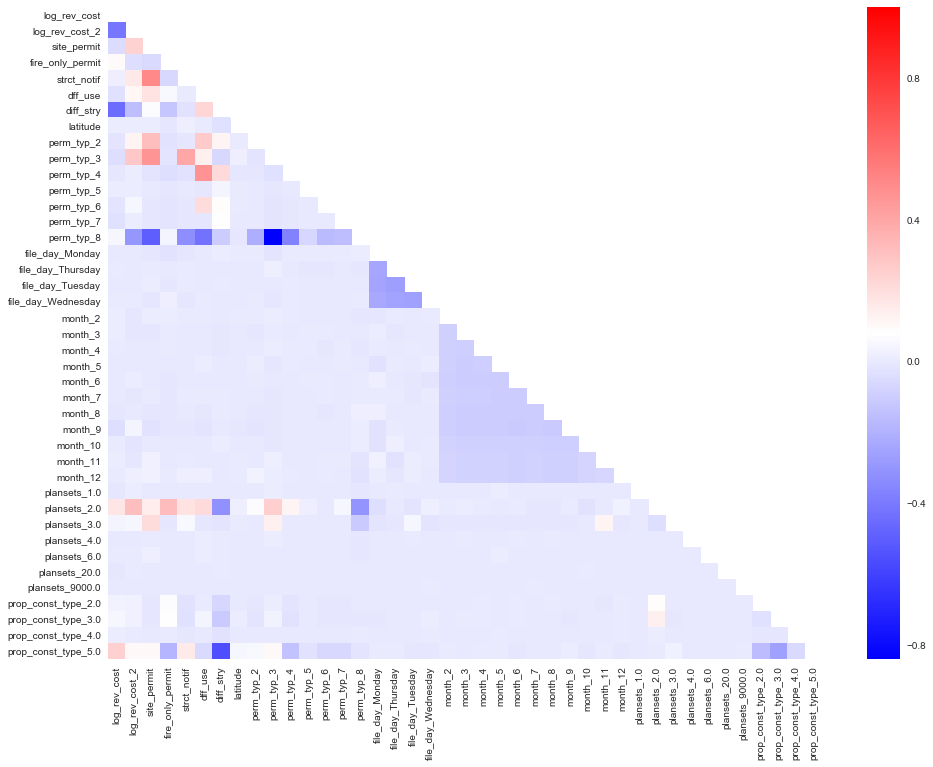

In [12]:
sns.set(style="white")
_ = plt.figure(figsize=(16,12))
mask = np.zeros_like(Xlr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
_ = sns.heatmap(Xlr.corr(),mask=mask,cmap='bwr')
sns.set(style="darkgrid")

In [13]:
# Call preprocess for logreg
Xl_tr,Xl_dev,Xl_te,yl_tr,yl_dev,yl_te = pre_process_Xy(Xlr,y)

#### Examine the Bias in Dataset

Wall time: 38.1 s


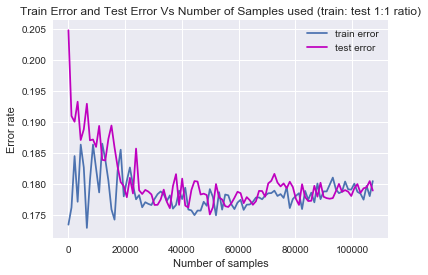

In [14]:
%%time
lr = LogisticRegression()
plot_train_test_error(lr,Xl_tr,yl_tr,N=100)

**Remarks:** The above plot indicates that pretty soon, with around 20,000 training samples, the error reaches steady state and model generalizes pretty well to test set. This gives a clue that high variance models might not be able to give considerable  performance boost compared to logistic regression.

In [15]:
%%time
parameters = {"C":[10,1000,10000],"class_weight":[None,'balanced']}
lr = do_classify(LogisticRegression(), parameters, Xl_tr,yl_tr,Xl_dev,yl_dev, score_func='f1_weighted', n_folds=10, n_jobs=-1,model_name='LogReg',label=1,prob_dec=1)

BEST {'C': 10000, 'class_weight': 'balanced'} 0.8114339064344989
############# LogReg ################
Accuracy on training data: 79.16%
Accuracy on test data:     78.82%
confusion_matrix on dev data
[[21222  4733    26]
 [  879  4125   469]
 [  323  1231  3155]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.95      0.82      0.88     25981
          1       0.41      0.75      0.53      5473
          2       0.86      0.67      0.75      4709

avg / total       0.85      0.79      0.81     36163

########################################################
Wall time: 1min 17s


#### Prepare the data for tree/ensemble based models. 

In [16]:
X['file_day'] = X['file_day'].astype('category').cat.codes
X['plansets'] = X['plansets'].astype('category').cat.codes
X['site_permit'] = X['site_permit'].astype('category').cat.codes
X['fire_only_permit'] = X['fire_only_permit'].astype('category').cat.codes
X['strct_notif'] = X['strct_notif'].astype('category').cat.codes
X['exist_const_type'] = X['exist_const_type'].astype('category').cat.codes
X['prop_const_type'] = X['prop_const_type'].astype('category').cat.codes
Xtr,Xdev,Xte,ytr,ydev,yte = pre_process_Xy(X,y)

In [17]:
%%time
parameters = {"max_depth": [12,14,None], 'min_samples_leaf': [1,2,4,6],"class_weight":[None,'balanced']}
tr = do_classify(DecisionTreeClassifier(), parameters, Xtr,ytr,Xdev,ydev, score_func='f1_weighted', n_folds=10, n_jobs=2,model_name='DecTree',label=1,prob_dec=1)

BEST {'class_weight': None, 'max_depth': 12, 'min_samples_leaf': 6} 0.8198444468893847
############# DecTree ################
Accuracy on training data: 83.68%
Accuracy on test data:     82.53%
confusion_matrix on dev data
[[24448  1473    60]
 [ 2840  2261   372]
 [  837   735  3137]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.87      0.94      0.90     25981
          1       0.51      0.41      0.45      5473
          2       0.88      0.67      0.76      4709

avg / total       0.82      0.83      0.82     36163

########################################################
Wall time: 1min 21s


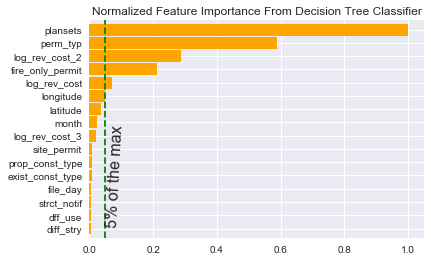

In [18]:
feature_labels = np.array(list(X.columns))
(pd.Series(tr.feature_importances_,index=feature_labels).sort_values(ascending=True)/np.max(tr.feature_importances_)).plot.barh(color='orange',width=0.9)
_ = plt.title('Normalized Feature Importance From Decision Tree Classifier')
_ = plt.axvline(0.05,linestyle='--',color='g')
_ = plt.text(0.05,7,'5% of the max',rotation=87,fontsize=16)

#### Evaluating the gains obtained by Feature Selection and Feature Engineering with Decision Trees

In [19]:
list_columns_by_importance = list((pd.Series(tr.feature_importances_,index=feature_labels).sort_values(ascending=False).index))
for i in np.arange(1,len(list_columns_by_importance)-1):
    columns_to_keep = list(list_columns_by_importance[:i])
    Xtr1 = Xtr[columns_to_keep]
    Xdev1 = Xdev[columns_to_keep]
    tr1 = do_classify(DecisionTreeClassifier(min_samples_leaf=6,class_weight=None, max_depth=12), None, Xtr1,ytr,Xdev1,ydev, score_func='f1_weighted', n_folds=5, n_jobs=2,model_name='DecTree',label=1,prob_dec=1,print_detail=0)

############# DecTree ################
Accuracy on training data: 71.98%
Accuracy on test data:     72.01%
f1 score:  0.60
############# DecTree ################
Accuracy on training data: 78.53%
Accuracy on test data:     78.40%
f1 score:  0.71
############# DecTree ################
Accuracy on training data: 82.37%
Accuracy on test data:     82.06%
f1 score:  0.81


C:\Users\Aparn\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


############# DecTree ################
Accuracy on training data: 82.76%
Accuracy on test data:     82.29%
f1 score:  0.81
############# DecTree ################
Accuracy on training data: 82.76%
Accuracy on test data:     82.29%
f1 score:  0.81
############# DecTree ################
Accuracy on training data: 83.25%
Accuracy on test data:     82.39%
f1 score:  0.81
############# DecTree ################
Accuracy on training data: 83.59%
Accuracy on test data:     82.45%
f1 score:  0.82
############# DecTree ################
Accuracy on training data: 83.56%
Accuracy on test data:     82.56%
f1 score:  0.81
############# DecTree ################
Accuracy on training data: 83.56%
Accuracy on test data:     82.58%
f1 score:  0.81
############# DecTree ################
Accuracy on training data: 83.54%
Accuracy on test data:     82.60%
f1 score:  0.81
############# DecTree ################
Accuracy on training data: 83.60%
Accuracy on test data:     82.61%
f1 score:  0.81
############# De

**Remarks:** The features are added one by one starting from most important feature. After adding 4 most important feature, we see hardly any improvement.

#### Bagging Classifier

Bagging Classifier is something in between Decision Trees and Random Forests. It is tried before Random Forests, to gain understanding of what really makes difference.

In [20]:
%%time
parameters = {"n_estimators":[10,100,200]}
bag = do_classify(BaggingClassifier(), parameters, Xtr,ytr,Xdev,ydev, score_func='f1_weighted', n_folds=5, n_jobs=2,model_name='Bagging',label=1,prob_dec=1)

BEST {'n_estimators': 200} 0.8361015541414217
############# Bagging ################
Accuracy on training data: 99.92%
Accuracy on test data:     84.59%
confusion_matrix on dev data
[[24406  1460   115]
 [ 2375  2763   335]
 [  693   594  3422]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.89      0.94      0.91     25981
          1       0.57      0.50      0.54      5473
          2       0.88      0.73      0.80      4709

avg / total       0.84      0.85      0.84     36163

########################################################
Wall time: 10min 4s


In [21]:
%%time
# This takes more than an hour to execute at times.
parameters =  {"max_depth": [12,14,None], 'min_samples_leaf': [1,2,4,6],"class_weight":[None,"balanced"],"n_estimators":[10,100,200,300]} #Including defaults
rf = do_classify(RandomForestClassifier(), parameters, Xtr,ytr,Xdev,ydev, score_func='f1_weighted', n_folds=5, n_jobs=2,model_name='RandomForest',label=1,prob_dec=1)

BEST {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200} 0.8359619640993101
############# RandomForest ################
Accuracy on training data: 95.35%
Accuracy on test data:     82.68%
confusion_matrix on dev data
[[22723  3125   133]
 [ 1344  3757   372]
 [  427   861  3421]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.93      0.87      0.90     25981
          1       0.49      0.69      0.57      5473
          2       0.87      0.73      0.79      4709

avg / total       0.85      0.83      0.84     36163

########################################################
Wall time: 1h 7min 23s


In [22]:
pd.Series(rf.feature_importances_,index=feature_labels).sort_values(ascending=False)

plansets            0.183515
perm_typ            0.127182
log_rev_cost_2      0.120524
longitude           0.104480
latitude            0.102183
log_rev_cost        0.085234
log_rev_cost_3      0.084233
month               0.053609
file_day            0.033587
fire_only_permit    0.023781
site_permit         0.023638
prop_const_type     0.019184
exist_const_type    0.018069
strct_notif         0.007549
dff_use             0.006665
diff_stry           0.006566
dtype: float64

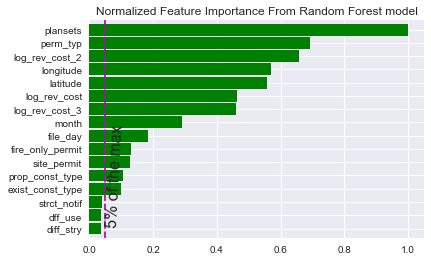

In [23]:
(pd.Series(rf.feature_importances_,index=feature_labels).sort_values(ascending=True)/np.max(rf.feature_importances_)).plot.barh(color='g',width=0.9)
_ = plt.title('Normalized Feature Importance From Random Forest model')
_ = plt.axvline(0.05,linestyle='--',color='m')
_ = plt.text(0.05,7,'5% of the max',rotation=87,fontsize=16)

#### Evaluating the gains obtained by Feature Selection and Feature Engineering with Random Forest

In [24]:
%%time
list_columns_by_importance = list((pd.Series(rf.feature_importances_,index=feature_labels).sort_values(ascending=False).index))
for i in np.arange(1,len(list_columns_by_importance)-4):
    columns_to_keep = list(list_columns_by_importance[:i])
    print(columns_to_keep)
    Xtr1 = Xtr[columns_to_keep]
    Xdev1 = Xdev[columns_to_keep]
    rf1 = do_classify(RandomForestClassifier(class_weight='balanced',max_depth=None,min_samples_leaf=2,n_estimators=200), None, Xtr1,ytr,Xdev1,ydev, score_func='f1_weighted', n_folds=5, n_jobs=2,model_name='RandForest',label=1,prob_dec=1,print_detail=0)

['plansets']
############# RandForest ################
Accuracy on training data: 63.78%
Accuracy on test data:     63.73%
f1 score:  0.65
['plansets', 'perm_typ']
############# RandForest ################
Accuracy on training data: 69.26%
Accuracy on test data:     68.94%
f1 score:  0.73
['plansets', 'perm_typ', 'log_rev_cost_2']
############# RandForest ################
Accuracy on training data: 75.41%
Accuracy on test data:     73.64%
f1 score:  0.77
['plansets', 'perm_typ', 'log_rev_cost_2', 'longitude']
############# RandForest ################
Accuracy on training data: 91.36%
Accuracy on test data:     80.06%
f1 score:  0.81
['plansets', 'perm_typ', 'log_rev_cost_2', 'longitude', 'latitude']
############# RandForest ################
Accuracy on training data: 94.89%
Accuracy on test data:     81.86%
f1 score:  0.83
['plansets', 'perm_typ', 'log_rev_cost_2', 'longitude', 'latitude', 'log_rev_cost']
############# RandForest ################
Accuracy on training data: 94.07%
Accur

**Remarks:** The five features [ 'plansets', 'perm_typ', 'log_rev_cost_2', 'longitude', 'latitude' ] consistently give improvements in accuracy and accuracy score. Out of the remaining, the amount of improvement attained changes with runs, as we have not fixed the random state. 

In [25]:
%%time
gb = do_classify(GradientBoostingClassifier(n_estimators=50), None, Xtr,ytr,Xdev,ydev, score_func='f1_weighted', n_folds=5, n_jobs=2,model_name='GradientBoosting',label=1,prob_dec=1) 

############# GradientBoosting ################
Accuracy on training data: 82.89%
Accuracy on test data:     82.63%
confusion_matrix on dev data
[[24554  1408    19]
 [ 2908  2215   350]
 [  853   742  3114]]
classification report on dev data
             precision    recall  f1-score   support

          0       0.87      0.95      0.90     25981
          1       0.51      0.40      0.45      5473
          2       0.89      0.66      0.76      4709

avg / total       0.82      0.83      0.82     36163

########################################################
Wall time: 11.8 s


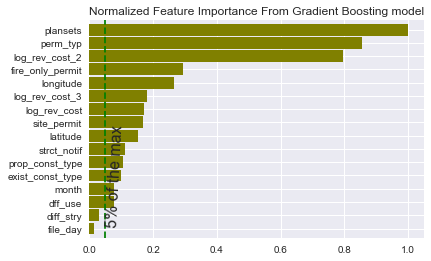

In [26]:
(pd.Series(gb.feature_importances_,index=feature_labels).sort_values(ascending=True)/np.max(gb.feature_importances_)).plot.barh(color='olive',width=0.9)
_ = plt.title('Normalized Feature Importance From Gradient Boosting model')
_ = plt.axvline(0.05,linestyle='--',color='g')
_ = plt.text(0.05,7,'5% of the max',rotation=87,fontsize=16)

### Find out the real performance of the model 
Real performance is found using held out set that is 20% of total number of records. This was never used in training or comparing across the models.

In [27]:
# The final Score using the chosen model and held out test set
ypred = rf.predict(Xte)
print(confusion_matrix(yte,ypred))
print(classification_report(yte,ypred))

[[22828  3033   119]
 [ 1277  3837   359]
 [  418   850  3441]]
             precision    recall  f1-score   support

          0       0.93      0.88      0.90     25980
          1       0.50      0.70      0.58      5473
          2       0.88      0.73      0.80      4709

avg / total       0.86      0.83      0.84     36162



## Scope for Future Work

+ Can gather more location based data, like housing price or crime data to reduce the bias
+ Try undersampling, oversampling techniques to handle class imbalance

## Conclusions

We did Data cleaning, EDA and inferential statistics on the data. Defined the time taken variable as a 3 - class classification problem, fitted a few models, did hyperparameter tuning and evaluated the performance. 

+ The Random Forest is the chosen model   
+ Wait times depend on Latitude and Longitude, this suggests correlation with location data, opens up several possibilities to collect more data
+ Logarithm of revised cost and its engineered versions are important features
+ Finally 5 features are found to be deterministic factors Plansets, Permit type, log_rev_cost_2, longitude, latitude. Sometimes when RandomForest can give slightly different important features, as seed is not fixed.

## References

1. [Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)
2. [Machine Learning Coursera](https://www.coursera.org/learn/machine-learning/)
3. [Structuring Machine Learning Projects Coursera](https://www.coursera.org/learn/machine-learning-projects)
4. [Inferential Statistics Coursera](https://www.coursera.org/learn/inferential-statistics-intro)
5. [Datacamp](https://www.datacamp.com) lectures, Springboard exercises

**Acknowledgment**

1. [Springboard](https://www.springboard.com/) team - Andrew, Chris, Guy Maskal and a few student friends - for the wonderful ecosystem!
2. Mentor [Rajiv Shah](http://rajivshah.com/) for driving this effort.